# Random Forest -  with greeks

- Random Forest, using the metadata found in the greeks.csv
- 80:20 train_test
- Mean imputing for numerical values 
- K-folds with n=10

### Step 1: Import libraries

---

In [13]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sklearn.metrics as metrics


from sklearn.model_selection import KFold
from mlxtend.plotting import heatmap
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import log_loss

#improve figure resolution
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'


pd.set_option('display.max_columns', None) #show all columns
pd.set_option('display.max_rows', None) #show all rows

### Step 2: Define functions

---

In [14]:
#auprc for metrics
def auprc(y_true, y_pred):
    precision, recall, _ = metrics.precision_recall_curve(y_true, y_pred)
    return metrics.auc(recall, precision)

In [15]:
def balanced_log_loss(y_true, y_pred):
    nc = np.bincount(y_true)
    return log_loss(y_true, y_pred, sample_weight = 1/nc[y_true], eps=1e-15)

In [16]:
#create dummy variables
def be_my_dummy(categorical_list, dataframe):
    dummy_dfs = []
    for smart_var in categorical_list:
        dummy_df = pd.get_dummies(dataframe[smart_var], prefix=smart_var, dtype=int)
        dummy_dfs.append(dummy_df)
        dataframe.drop(smart_var, axis=1, inplace=True)  
        
    dataframe.drop(["Id"], axis=1, inplace=True)  # Drop the "ID" variable from the DataFrame
    dataframe_with_dummies = pd.concat([dataframe] + dummy_dfs, axis=1)
    return dataframe_with_dummies


In [17]:
#output trees for each fold
# def output_model_plot(fold_index, model, tree_idx=0, max_depth=3):
#     filename = f"fold_{fold_index}_rt_greek.html"
    
#     with open(filename, "w") as f:
#         f.write(tfdf.model_plotter.plot_model(model, tree_idx=tree_idx, max_depth=max_depth))

### Step 3: Read data

Clean data: mean imputing, one-hot encoding for EJ, Epsilon as datetime, EpochTime as epoch time

---

In [18]:
os.chdir('/Users/ecompu/Library/CloudStorage/OneDrive-Personal/Berkeley/W207_Machine_Learning/mids-207-final-project-summer23-Burzon-Brown-Caldera-Gomez/icr-identify-age-related-conditions/Preprocessed_Data')

    
train_df = pd.read_csv('train_df.csv')
test_df = pd.read_csv('test_df.csv')

X_train = np.loadtxt("X_train.csv",
                 delimiter=",", dtype=str)
X_test = np.loadtxt("X_test.csv",
                 delimiter=",", dtype=str)
y_train = np.loadtxt("y_train.csv",
                 delimiter=",", dtype=str)
y_test = np.loadtxt("y_test.csv",
                 delimiter=",", dtype=str)

print('Shape X_train: ', X_train.shape, '\nShape X_test: ', X_test.shape,
      '\nShape y_train: ', y_train.shape, '\nShape y_test:', y_test.shape)

Shape X_train:  (494, 65) 
Shape X_test:  (125, 65) 
Shape y_train:  (494, 2) 
Shape y_test: (125, 2)


### Step 4: Feature engineering

- One-hot encoding for categorical variables in train and test data


---

In [19]:
columns_to_dummy = ['Beta', 'Gamma', 'Delta']
train_df = be_my_dummy(columns_to_dummy,train_df)
test_df = be_my_dummy(columns_to_dummy,test_df)
print("train, after:", train_df.columns)
print("test, after:",test_df.columns) #not all columns are included but it makes sense to do it this way...

train, after: Index(['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN', 'BP',
       'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU',
       'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB',
       'EE', 'EG', 'EH', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL', 'FR',
       'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'Class', 'EJ_A', 'EJ_B',
       'Alpha', 'Epsilon', 'EpochTime', 'Beta_A', 'Beta_B', 'Beta_C',
       'Gamma_A', 'Gamma_B', 'Gamma_E', 'Gamma_F', 'Gamma_G', 'Gamma_H',
       'Gamma_M', 'Gamma_N', 'Delta_A', 'Delta_B', 'Delta_C', 'Delta_D'],
      dtype='object')
test, after: Index(['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN', 'BP',
       'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU',
       'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB',
       'EE', 'EG', 'EH', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL', 'FR',
       'FS', 'GB', '

### Step 5: EDA

1. See if there is a difference between Class 0 and Class 1 based on epoch time
2. See if there is a difference between Alpha based on epoch time
---

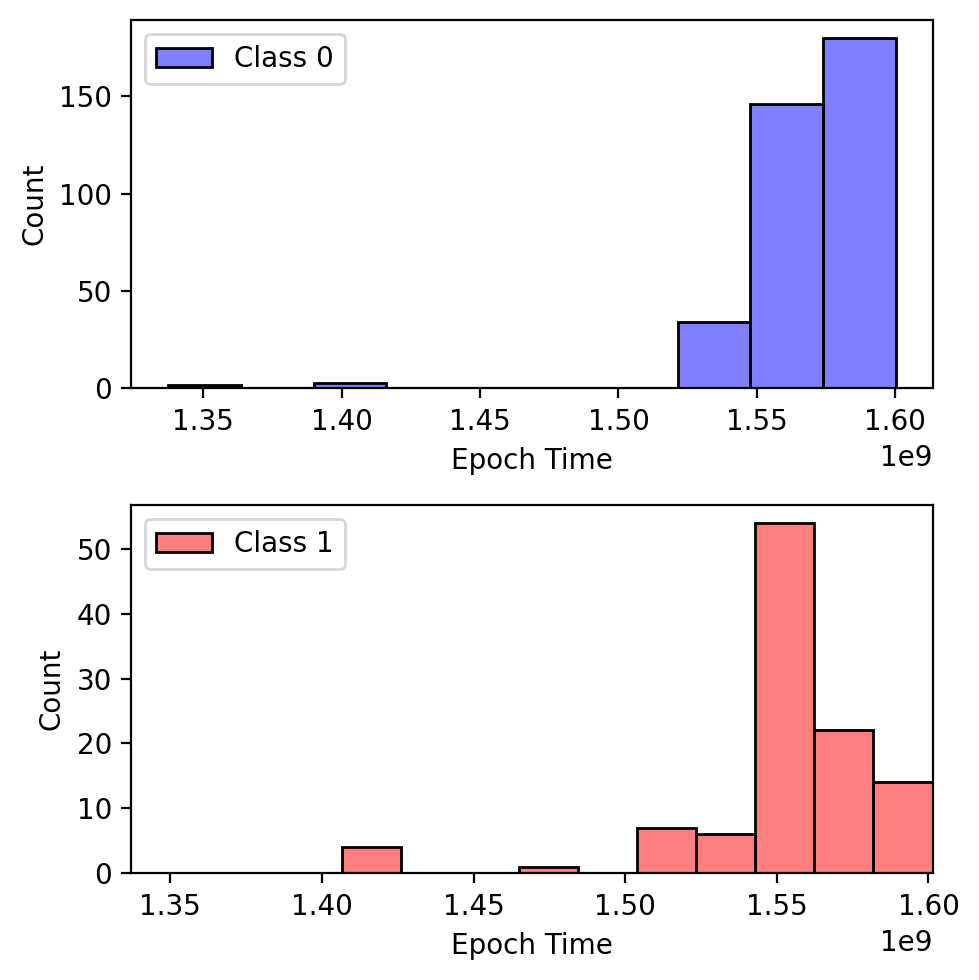

In [20]:

# Subset the DataFrame for class 0 and class 1
class_0_data = train_df[train_df["Class"] == 0]
class_1_data = train_df[train_df["Class"] == 1]

# Set the figsize
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(5, 5))

num_bins = 10


# Plot the histogram for class 0 in the first subplot
sns.histplot(data=class_0_data, x="EpochTime", color="blue", label="Class 0", alpha=0.5, bins=num_bins, ax=ax1)
ax1.legend()
ax1.set_xlabel("Epoch Time")
ax1.set_ylabel("Count")

# Plot the histogram for class 1 in the second subplot
sns.histplot(data=class_1_data, x="EpochTime", color="red", label="Class 1", alpha=0.5, bins=num_bins,ax=ax2)
ax2.legend()
ax2.set_xlabel("Epoch Time")
ax2.set_ylabel("Count")

# Set the same x-axis limits for both subplots
plt.xlim([train_df["EpochTime"].min(), train_df["EpochTime"].max()])

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

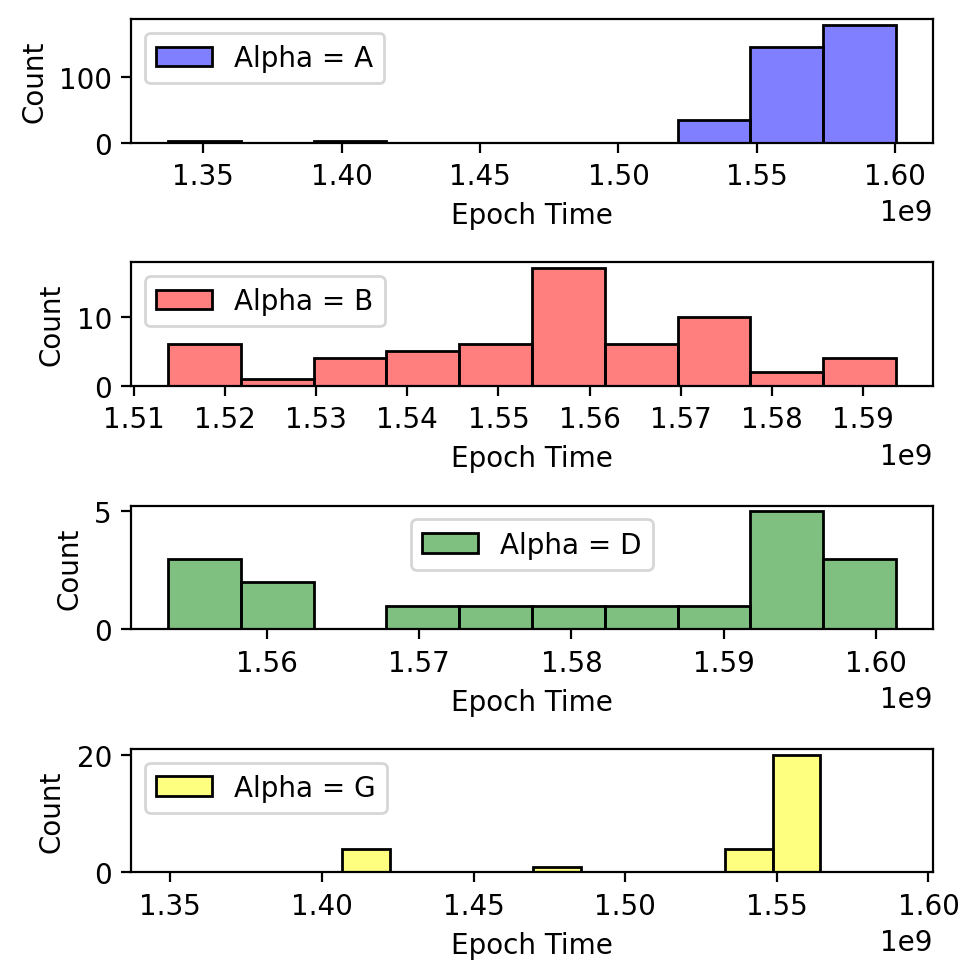

In [21]:
# Subset the DataFrame
A_data = train_df[train_df["Alpha"] == 'A']
G_data = train_df[train_df["Alpha"] == 'G']
B_data = train_df[train_df["Alpha"] == 'B']
D_data = train_df[train_df["Alpha"] == 'D']


# Set the figsize
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(5, 5))

num_bins = 10


# Plot the histogram for A
sns.histplot(data=A_data, x="EpochTime", color="blue", label="Alpha = A", alpha=0.5, bins=num_bins, ax=ax1)
ax1.legend()
ax1.set_xlabel("Epoch Time")
ax1.set_ylabel("Count")

# Plot the histogram for B
sns.histplot(data=B_data, x="EpochTime", color="red", label="Alpha = B", alpha=0.5, bins=num_bins,ax=ax2)
ax2.legend()
ax2.set_xlabel("Epoch Time")
ax2.set_ylabel("Count")

# Plot the histogram for D
sns.histplot(data=D_data, x="EpochTime", color="green", label="Alpha = D", alpha=0.5, bins=num_bins,ax=ax3)
ax3.legend()
ax3.set_xlabel("Epoch Time")
ax3.set_ylabel("Count")

# Plot the histogram for G
sns.histplot(data=G_data, x="EpochTime", color="yellow", label="Alpha = G", alpha=0.5, bins=num_bins,ax=ax4)
ax4.legend()
ax4.set_xlabel("Epoch Time")
ax4.set_ylabel("Count")

# Set the same x-axis limits for both subplots
plt.xlim([train_df["EpochTime"].min(), train_df["EpochTime"].max()])


# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [22]:
#drop alpha and epsilon from features adn rename to avoid confusion when running the model 
full_train_df = train_df.drop(['Alpha','Epsilon'], axis=1)
full_train_df.columns

Index(['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN', 'BP',
       'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU',
       'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB',
       'EE', 'EG', 'EH', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL', 'FR',
       'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'Class', 'EJ_A', 'EJ_B',
       'EpochTime', 'Beta_A', 'Beta_B', 'Beta_C', 'Gamma_A', 'Gamma_B',
       'Gamma_E', 'Gamma_F', 'Gamma_G', 'Gamma_H', 'Gamma_M', 'Gamma_N',
       'Delta_A', 'Delta_B', 'Delta_C', 'Delta_D'],
      dtype='object')

### Step 7: Learning Model

---

1. Class weighting
2. K-fold cross-validation
3. Hyperparameter tuning: Number of trees, depth of trees

``class weighting``


In [23]:
#class weighting

# Calculate the number of samples for each label.
neg, pos = np.bincount(full_train_df['Class'])

# Calculate total samples.
total = neg + pos

# Calculate the weight for each label.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.64
Weight for class 1: 2.28


``k-folds cross validation``

In [24]:
#estimate performance with OOF 
# Create list of ids for the creation of oof dataframe.
ID_LIST = full_train_df.index

# # Create a dataframe of required size with zero values (493)
oof = pd.DataFrame(data=np.zeros((len(ID_LIST),1)), index=ID_LIST)

# Create an empty dictionary to store the models trained for each fold.
models = {}

# Create empty dict to save metrics for the models trained for each fold.
bll = {}
auprc = {}

# Save the name of the label column to a variable.
label = "Class"

In [25]:
kf = KFold(n_splits=10)
ft_cols = full_train_df.columns
ft_cols

Index(['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN', 'BP',
       'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU',
       'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB',
       'EE', 'EG', 'EH', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL', 'FR',
       'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'Class', 'EJ_A', 'EJ_B',
       'EpochTime', 'Beta_A', 'Beta_B', 'Beta_C', 'Gamma_A', 'Gamma_B',
       'Gamma_E', 'Gamma_F', 'Gamma_G', 'Gamma_H', 'Gamma_M', 'Gamma_N',
       'Delta_A', 'Delta_B', 'Delta_C', 'Delta_D'],
      dtype='object')

`Build the model` 


In [26]:
for i, (train_index, valid_index) in enumerate(kf.split(X=full_train_df)):
        print('##### Fold',i+1)

        # Fetch values corresponding to the index 
        train_df = full_train_df.iloc[train_index]
        valid_df = full_train_df.iloc[valid_index]
        valid_ids = valid_df.index.values
        
        # Select only feature columns for training.
        train_df = train_df[ft_cols]
        valid_df = valid_df[ft_cols]
        

        train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label=label)
        valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df, label=label)

        # Define the model and metrics
        rf = tfdf.keras.RandomForestModel()

##### Fold 1


Use /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmpxqx2d0t7 as temporary training directory
##### Fold 2


Use /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmply__yz3w as temporary training directory
##### Fold 3


Use /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmpr60wgb46 as temporary training directory
##### Fold 4


Use /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmpjcbo7__g as temporary training directory
##### Fold 5


Use /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmpiy_1nadu as temporary training directory
##### Fold 6


Use /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmphn9s6fj2 as temporary training directory
##### Fold 7


Use /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmpo_9zv9gb as temporary training directory
##### Fold 8


Use /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmpdr23a2xm as temporary training directory
##### Fold 9


Use /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmpueuhwlmd as temporary training directory
##### Fold 10


Use /var/folders/11/gf1_57v92yqfscw0h2lk8v700000gn/T/tmpf93220ox as temporary training directory


`Compile the model `

In [27]:
for i, (train_index, valid_index) in enumerate(kf.split(X=full_train_df)):
    rf.compile(metrics=[balanced_log_loss, tf.keras.metrics.AUC(curve="PR")]) #change from accuracy to AUPRC and balanced log-loss

`Fit the model `

In [12]:
for i, (train_index, valid_index) in enumerate(kf.split(X=full_train_df)):

    rf.fit(x=train_ds, class_weight=class_weight)


    # Store the model
    models[f"fold_{i+1}"] = rf
            
    # Predict OOF value for validation data
    predict = rf.predict(x=valid_ds)
            
    # Store the predictions in oof dataframe
    oof.loc[valid_ids, 0] = predict.flatten() 
            
    # Evaluate and store the metrics in respective dicts (second part not sure working, nor that balanced_log_loss is either)
    evaluation = rf.evaluate(x=valid_ds,return_dict=True)
    # bll[f"fold_{i+1}"] = evaluation["bll"]
    # auprc[f"fold_{i+1}"]= evaluation["auprc"]

NameError: name 'kf' is not defined

`Visualize the model` (write a function later)

In [70]:
os.chdir('/Users/ecompu/Library/CloudStorage/OneDrive-Personal/Berkeley/W207_Machine_Learning/mids-207-final-project-summer23-Burzon-Brown-Caldera-Gomez/icr-identify-age-related-conditions/Juliana\'s jungle gym/Trees/')

with open("fold_1_rt_greek.html", "w") as f: 
    f.write(tfdf.model_plotter.plot_model(models['fold_1'], tree_idx=0, max_depth=3))


with open("fold_2_rt_greek.html", "w") as f: 
    f.write(tfdf.model_plotter.plot_model(models['fold_2'], tree_idx=0, max_depth=3))


with open("fold_3_rt_greek.html", "w") as f: 
    f.write(tfdf.model_plotter.plot_model(models['fold_3'], tree_idx=0, max_depth=3))   

#fold 6 not showing loss, for some reason
with open("fold_6_rt_greek.html", "w") as f: 
    f.write(tfdf.model_plotter.plot_model(models['fold_6'], tree_idx=0, max_depth=3))



`Plot loss` (currently normal loss, need to change it)

In [72]:
models.keys()

dict_keys(['fold_1', 'fold_2', 'fold_3', 'fold_4', 'fold_5', 'fold_6', 'fold_7', 'fold_8', 'fold_9', 'fold_10'])

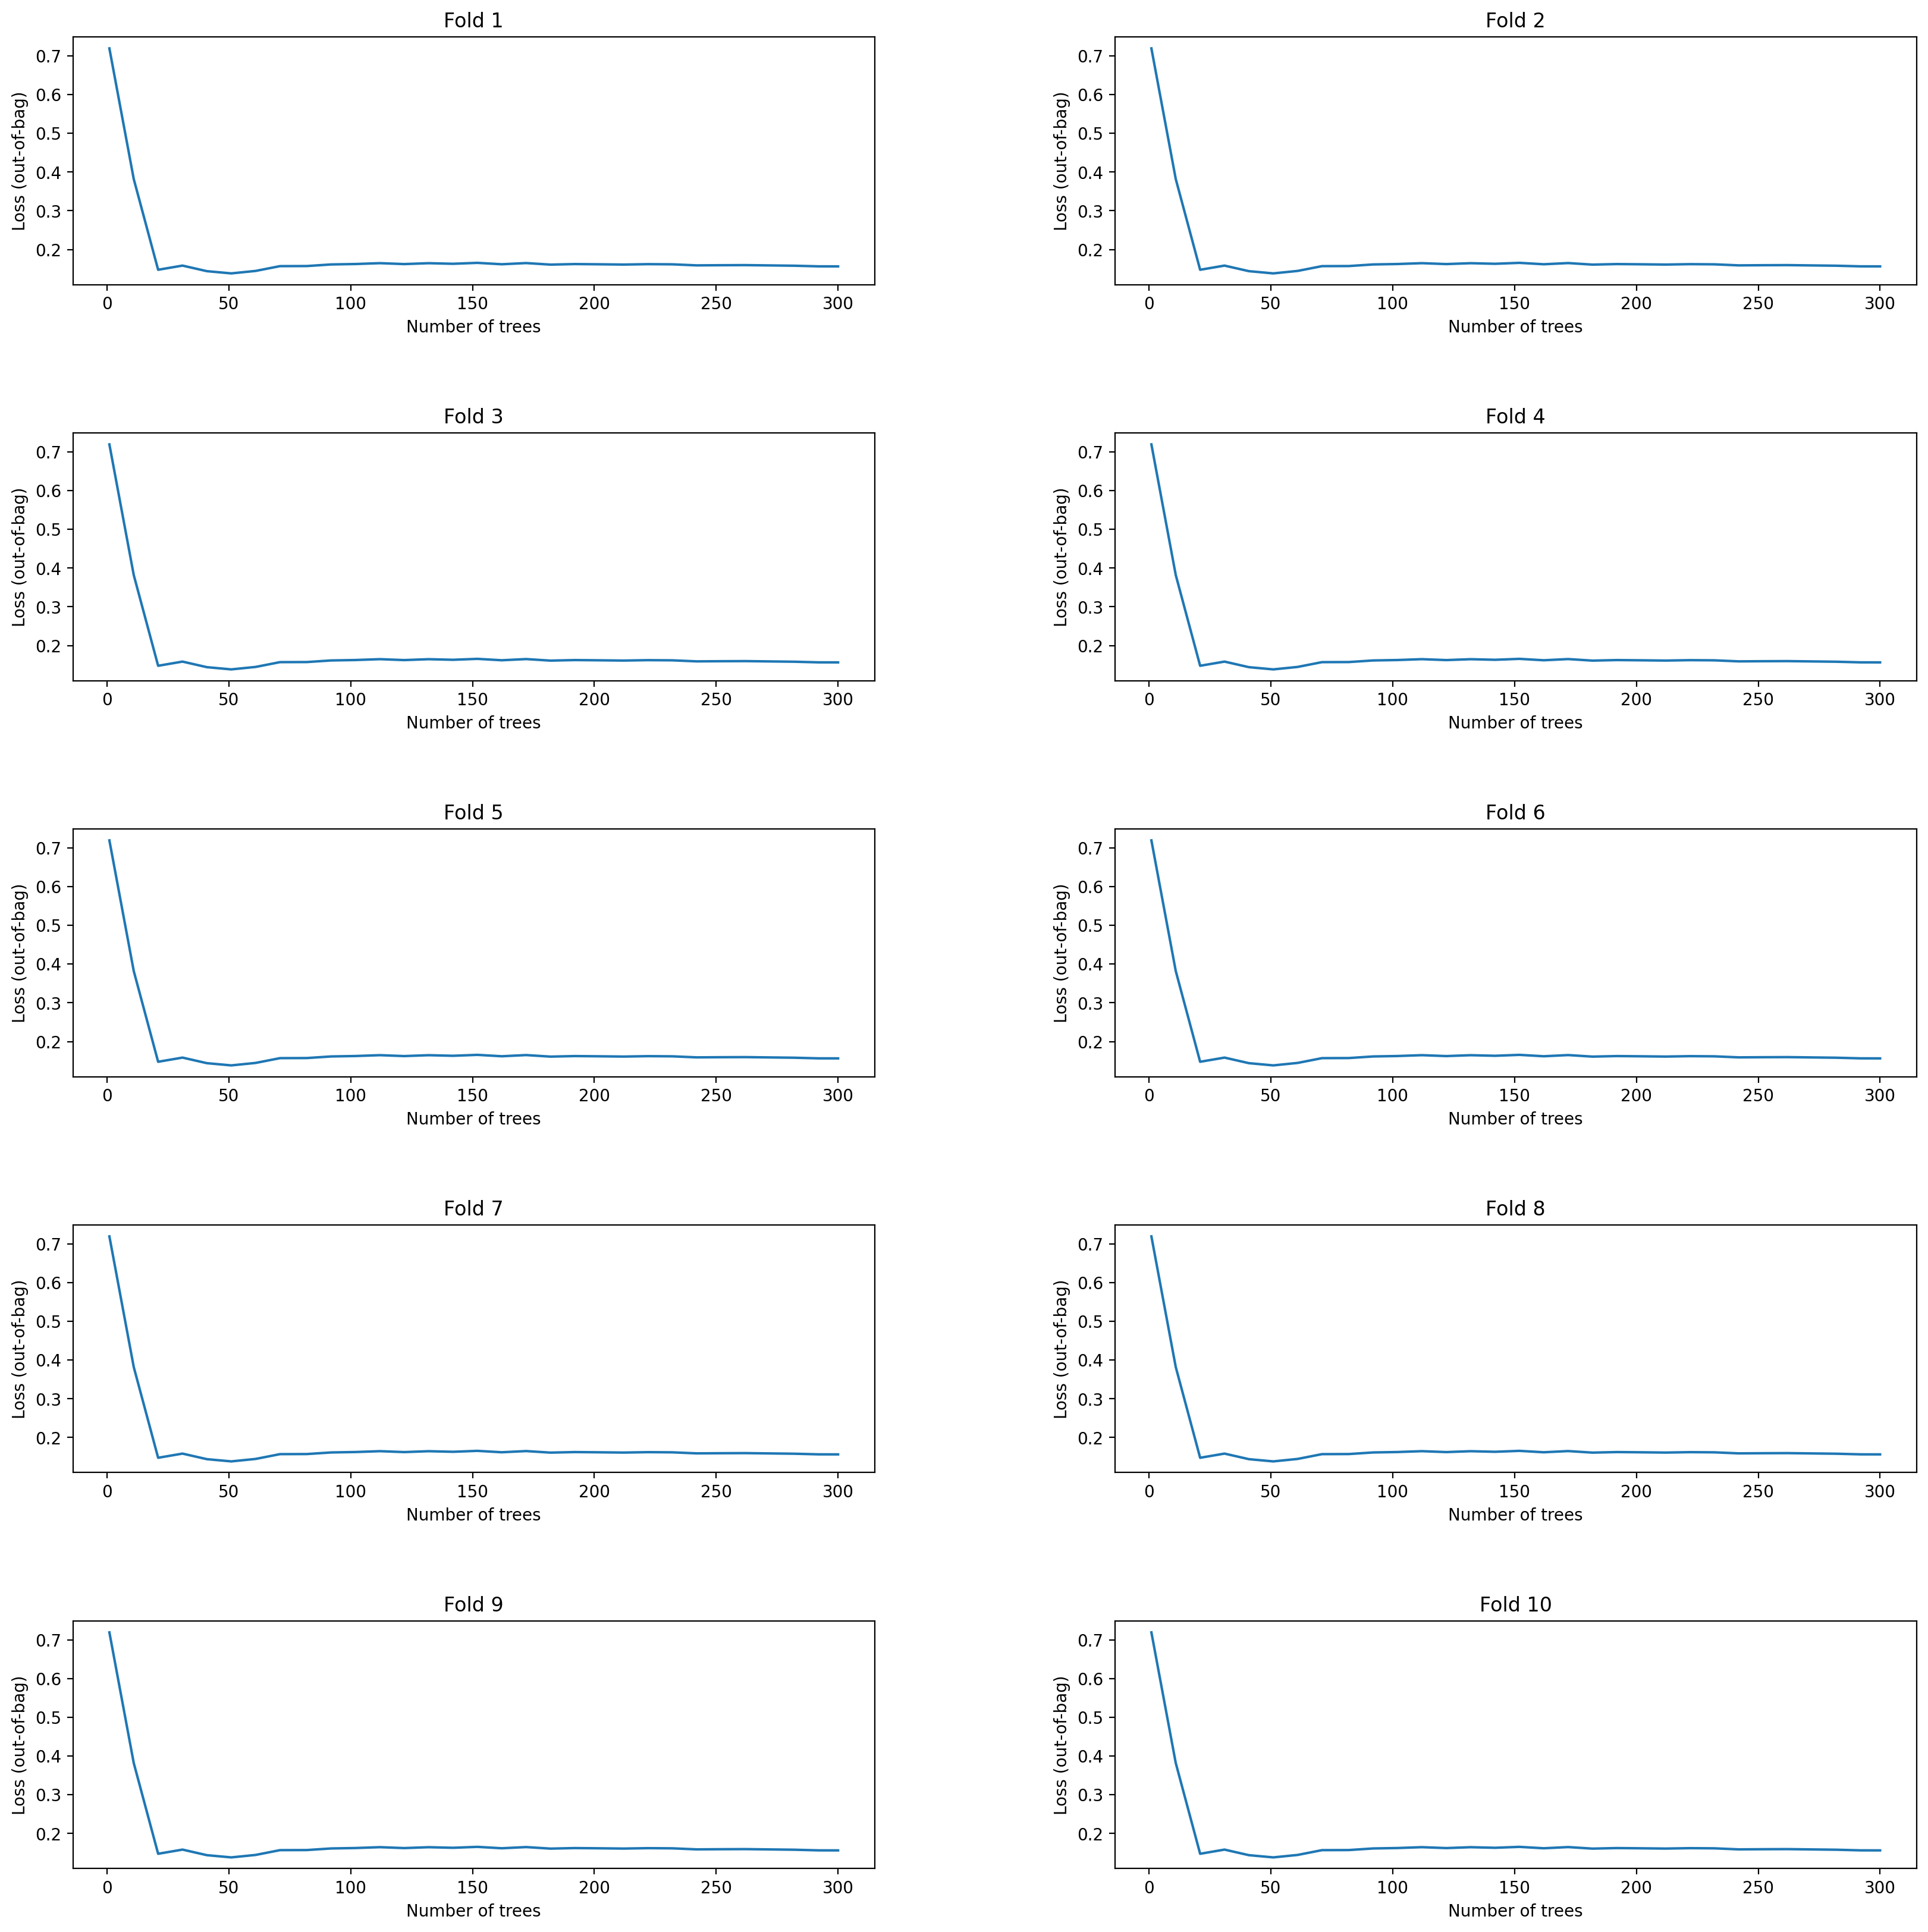

In [74]:
num_folds = len(models)
num_rows = (num_folds + 1) // 2  # Number of rows for the subplots grid
num_cols = min(num_folds, 2)  # Number of columns for the subplots grid

figure, axis = plt.subplots(num_rows, num_cols, figsize=(20, 20))
plt.subplots_adjust(hspace=0.6, wspace=0.3)

for i, fold_no in enumerate(models.keys()):
    row = i // num_cols
    col = i % num_cols
    logs = models[fold_no].make_inspector().training_logs()
    axis[row, col].plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
    axis[row, col].set_title(f"Fold {i+1}")
    axis[row, col].set_xlabel('Number of trees')
    axis[row, col].set_ylabel('Loss (out-of-bag)')

# Hide any empty subplots in the last row if it exists
if num_folds % 2 != 0:
    axis[-1, -1].set_visible(False)

plt.show()

### Step 8: Evaluation

---